**Further train DeepCell Models with K's Data and Make Predictions**<br>
The model has three heads: inner distance, outer distance, and fgbg. It works on tensorflow 2.7.1.<br>
We first train a model with nucleus data from the Tissuenet V1.0 dataset and save the model. <br>
We then further train the model via deepcell.training.train_model_sample, which allows arbitrary size images and uses window_size to control patch size.
There are a total of 12,574 training instances.

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
model_path = 'tn1.0_nuclear_K.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
epochs=60 # 7 sec per epoch
label="nuclear_K"

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [4]:
import glob
INPUT_PATH="images/training/"
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

7
['images/training/M872956_JML_Position9_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD3_train_img.png', 'images/training/M926910_CFL_Position7_CD3_train_img.png', 'images/training/M926910_CFL_Position13_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD8_train_img.png', 'images/training/M872956_JML_Position10_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD4_train_img.png']


In [12]:
imgs = [io.imread(CURR_IM_NAME)[:,:,0] for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

# np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs
# train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

(7, 1040, 1159, 1)
(7, 1040, 1159, 1)


In [6]:
# resize image
image_mpp=1
shape = X_train.shape
scale_factor = image_mpp / 0.65
new_shape = (int(shape[1] * scale_factor),
             int(shape[2] * scale_factor))

X_train = resize(X_train, new_shape, data_format='channels_last')
y_train = resize(y_train, new_shape, data_format='channels_last')
print(X_train.shape)

(7, 1599, 1783, 1)


In [20]:
# write resized images and masks. saved to images/training
for i in range(7):
    io.imsave(FILENAMES[i].replace("_img","_resized_img").replace("training","training_resized"), img_as_ubyte(X_train[i,:,:,0]))

In [21]:
for i in range(7):
    io.imsave(FILENAMES[i].replace("_img","_resized_masks").replace("training","training_resized"), img_as_ubyte(y_train[i,:,:,0]))

/tmp/ipykernel_16842/1971877337.py:2: UserWarning: images/training_resized/M872956_JML_Position9_CD3_train_resized_masks.png is a low contrast image
  io.imsave(FILENAMES[i].replace("_img","_resized_masks").replace("training","training_resized"), img_as_ubyte(y_train[i,:,:,0]))
/tmp/ipykernel_16842/1971877337.py:2: UserWarning: images/training_resized/M872956_JML_Position8_CD3_train_resized_masks.png is a low contrast image
  io.imsave(FILENAMES[i].replace("_img","_resized_masks").replace("training","training_resized"), img_as_ubyte(y_train[i,:,:,0]))
/tmp/ipykernel_16842/1971877337.py:2: UserWarning: images/training_resized/M926910_CFL_Position7_CD3_train_resized_masks.png is a low contrast image
  io.imsave(FILENAMES[i].replace("_img","_resized_masks").replace("training","training_resized"), img_as_ubyte(y_train[i,:,:,0]))
/tmp/ipykernel_16842/1971877337.py:2: UserWarning: images/training_resized/M926910_CFL_Position13_CD3_train_resized_masks.png is a low contrast image
  io.imsave(F

In [24]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(starting_model_path, by_name=True)

2022-11-02 18:59:08.777994: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [28]:
# get tile info 
from deepcell.applications import NuclearSegmentation
app1 = NuclearSegmentation(prediction_model)

y, tile_info = app1._tile_input(np.expand_dims(X_train[0,...],0))
print(X_train.shape)
print(y.shape)
print(tile_info)


(7, 1599, 1783, 1)
(20, 512, 512, 1)
{'batches': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'x_starts': [0, 0, 0, 0, 0, 384, 384, 384, 384, 384, 768, 768, 768, 768, 768, 1152, 1152, 1152, 1152, 1152], 'x_ends': [512, 512, 512, 512, 512, 896, 896, 896, 896, 896, 1280, 1280, 1280, 1280, 1280, 1664, 1664, 1664, 1664, 1664], 'y_starts': [0, 384, 768, 1152, 1536, 0, 384, 768, 1152, 1536, 0, 384, 768, 1152, 1536, 0, 384, 768, 1152, 1536], 'y_ends': [512, 896, 1280, 1664, 2048, 512, 896, 1280, 1664, 2048, 512, 896, 1280, 1664, 2048, 512, 896, 1280, 1664, 2048], 'overlaps_x': [(0, 128), (0, 128), (0, 128), (0, 128), (0, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 128), (128, 0), (128, 0), (128, 0), (128, 0), (128, 0)], 'overlaps_y': [(0, 128), (128, 128), (128, 128), (128, 128), (128, 0), (0, 128), (128, 128), (128, 128), (128, 128), (128, 0), (0, 128), (128, 128), (128, 128), (128, 128), (128, 0), (

In [40]:
seed=0
min_objects = 2

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
# no need to define width_shift_range or height_shift_range 
# because crops will be taken randomly over the image and not just the center (cropping.py)
datagen = image_generators.CroppingDataGenerator(
    crop_size=(512, 512),
    # datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 1 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

12574


In [23]:
# x_tmp, y_tmp=train_data.next()

/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


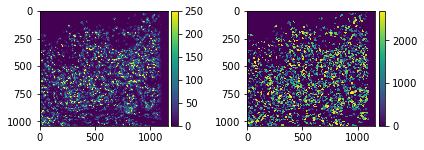

In [29]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [41]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [42]:
train_data.y.shape[0] // batch_size

7

In [43]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=2, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-02 22:01:33.186590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-02 22:01:33.187705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-02 22:01:33.188799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/2
7/7 [==============================] - ETA: 0s - loss: 0.0264 - semantic_0_loss: 0.0101 - semantic_1_loss: 0.0135 - semantic_2_loss: 0.0028
Epoch 00001: loss improved from inf to 0.02643, saving model to tn1.0_nuclear_K.h5
7/7 [==============================] - 33s 2s/step - loss: 0.0264 - semantic_0_loss: 0.0101 - semantic_1_loss: 0.0135 - semantic_2_loss: 0.0028 - lr: 1.0000e-04
Epoch 2/2
7/7 [==============================] - ETA: 0s - loss: 0.0232 - semantic_0_loss: 0.0090 - semantic_1_loss: 0.0122 - semantic_2_loss: 0.0020
Epoch 00002: loss improved from 0.02643 to 0.02321, saving model to tn1.0_nuclear_K.h5
7/7 [==============================] - 18s 3s/step - loss: 0.0232 - semantic_0_loss: 0.0090 - semantic_1_loss: 0.0122 - semantic_2_loss: 0.0020 - lr: 9.9000e-05


<B>Make predictions on Nuclear test dataset.</B> 

In [44]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [45]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [46]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [47]:
APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=1)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.3526717557251908, 'M872956_JML_Position10_CD3_test_img.png': 0.44223826714801445, 'M872956_JML_Position8_CD8_test_img.png': 0.4784688995215311, 'M926910_CFL_Position13_CD3_test_img.png': 0.25059101654846333, 'M872956_JML_Position8_CD3_test_img.png': 0.4845360824742268, 'M872956_JML_Position8_CD4_test_img.png': 0.42379958246346555, 'M872956_JML_Position9_CD3_test_img.png': 0.39

In [ ]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_tn_'+label+'.txt', index=False, header=False)

**mAP**<br>
image_mpp default: .<br>
image_mpp=1: .34<br>
image_mpp=2: .<br>